# NESTML STDP windows tutorial

In this tutorial, we will plot the "window function", relating the weight change of a synapse to the relative timing of a single pair of pre- and postsynaptic spikes. This type of synaptic plasticity is commonly known as spike-timing depdendent plasticity (STDP).

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import nest
import numpy as np
import os
from pynestml.frontend.pynestml_frontend import to_nest, install_nest

NEST_SIMULATOR_INSTALL_LOCATION = nest.ll_api.sli_func("statusdict/prefix ::")

## Preliminaries

Experiments have shown that synaptic strength changes as a function of the precise spike timing of the presynaptic and postsynaptic neurons. If the pre neuron fires an action potential strictly before the post neuron, the synapse connecting them will be strengthened (“facilitated”). If the pre neuron fires after the post neuron, the synapse will be weakened (“depressed”). The depression and facilitation effects become stronger when the spikes occurred closer together in time. This is illustrated by empirical results (open circles), fitted by exponential curves (solid lines).

<div>
<img src="attachment:image.png" width="500">
</div>

*Asymmetric STDP learning window. Spike-timing window of STDP for the induction of synaptic potentiation and depression characterized in hippocampal cultures. Data points from Bi and Poo (1998) [18], represent the relative change in the amplitude of EPSC after repetitive correlated activity of pre-post spike pairs. The LTP (+) and LTD (-) windows are fitted by the exponential function ∆g = A ± exp(−|∆t|/τ), with parameters A + = 0.86, A − = −0.25, τ + = 19 ms, and τ − = 34 ms. Adopted from Bi and Wang (2002).*
We will define the theoretical model following [3]_.

A pair of spikes in the input and the output cell, at times $t_i$ and $t_j$ respectively, induces a change $\Delta w$ in the weight $w$:

\begin{equation}
\Delta^\pm w = \pm \lambda \cdot f_\pm(w) \cdot K(|t_o - t_i|)
\end{equation}

The weight is increased by $\Delta^+ w$ when $t_o>t_i$ and decreased by $\Delta^- w$ when $t_i>t_o$. The temporal dependence of the update is defined by the filter kernel $K$ which is taken to be $K(t) = \exp(-t/\tau)$. The coefficient $\lambda\in\mathbb{R}$ sets the magnitude of the update. The functions $f_\pm(w)$ determine the relative magnitude of the changes in the positive and negative direction. These are here taken as

\begin{align}
f_+(w) &= (1 - w)^{\mu_+}\\
f_-(w) &= \alpha w^{\mu_-}
\end{align}

with the parameter $\alpha\in\mathbb{R}, \alpha>0$ allowing to set an asymmetry between increasing and decreasing the synaptic efficacy, and $\mu_\pm\in\{0,1\}` allowing to choose between four different kinds of STDP (for further references, see https://nest-simulator.readthedocs.io/en/nest-2.20.1/models/stdp.html?highlight=stdp#_CPPv4I0EN4nest14STDPConnectionE).

To implement the kernel, we use two extra state variables, one presynaptic so-called *trace value* and another postsynaptic trace value. These maintain a history of neuron spikes, being incremented by 1 whenever a spike is generated, and decaying back to zero exponentially; in other words, a convolution between the exponentially decaying kernel and the emitted spike train:

\begin{equation}
\text{tr_pre} = K \ast \sum_i \delta_{pre,i}
\end{equation}

and

\begin{equation}
\text{tr_post} = K \ast \sum_i \delta_{post,i}
\end{equation}

These are implemented in the NESTML model as follows:

```
  equations:
    # all-to-all trace of presynaptic neuron
    kernel pre_tr_kernel = exp(-t / tau_tr_pre)
    inline pre_tr real = convolve(pre_tr_kernel, pre_spikes)

    # all-to-all trace of postsynaptic neuron
    kernel post_tr_kernel = exp(-t / tau_tr_post)
    inline post_tr real = convolve(post_tr_kernel, post_spikes)
end
```

with time constants defined as parameters:

```
   parameters:
     tau_tr_pre ms = 20 ms
     tau_tr_post ms = 20 ms
   end
```

With the traces in place, the weight updates can then be expressed closely following the mathematical definitions (repeated here for convenience).

Begin by defining the weight and its initial value:

```
   state:
     w real = 1.
   end
```

The update rule for facilitation:

\begin{equation}
\Delta^+ w = \lambda \cdot (1 - w)^{\mu_{plus}} \cdot \text{pre_trace}
\end{equation}

Note that the only difference is that scaling with an absolute maximum weight ``Wmax`` was added:

```
   onReceive(post_spikes):
     # potentiate synapse
     w_ real = Wmax * ( w / Wmax  + (lambda * ( 1. - ( w / Wmax ) )**mu_plus * pre_trace ))
     w = min(Wmax, w_)
   end
```

The update rule for depression:

\begin{equation}
\Delta^- w = w - \alpha \cdot \lambda \cdot w^{\mu_{minus}} \cdot \text{post_trace}
\end{equation}

```
   onReceive(pre_spikes):
     # depress synapse
     w_ real = Wmax * ( w / Wmax  - ( alpha * lambda * ( w / Wmax )**mu_minus * post_trace ))
     w = max(Wmin, w_)

     # deliver spike to postsynaptic partner
     deliver_spike(w, the_delay)
   end
```

Finally, parameters are defined:

```
   parameters:
     lambda real = .01
     tau_tr_pre ms = 20 ms
     tau_tr_post ms = 20 ms
     alpha real = 1.
     mu_plus real = 1.
     mu_minus real = 1.
     Wmax real = 100.
     Wmin real = 0.
   end
```

The NESTML STDP synapse integration test (``tests/nest_tests/stdp_window_test.py``) runs the model for a variety of pre/post spike timings, and measures the weight change numerically. We can use this to verify that our model approximates the correct STDP window. Note that the dendritic delay in this example has been set to 10 ms, to make its effect on the STDP window more clear: it is not centered around zero, but shifted to the left by the dendritic delay.

.. figure:: https://raw.githubusercontent.com/nest/nestml/c4c47d053077b11ad385d5f882696248a55b31af/doc/fig/stdp_test_window.png

   STDP window, obtained from numerical simulation, for purely additive STDP (mu_minus = mu_plus = 0)

## Generating code with NESTML

### Formulating the model in NESTML

To generate fast code, NESTML needs to process the synapse model together with the neuron model that will be its postsynaptic partner in the network instantiantion.

In this tutorial, we will use a very simple integrate-and-fire model, where arriving spikes cause an instantaneous increment of the membrane potential. Let's download the model from the NESTML repository so it becomes available locally:

In [2]:
import urllib.request 
if not os.path.isdir("models"):
    os.makedirs("models")
urllib.request.urlretrieve("https://raw.githubusercontent.com/nest/nestml/master/models/iaf_psc_delta.nestml",
                           "models/iaf_psc_delta.nestml")

('models/iaf_psc_delta.nestml', <http.client.HTTPMessage at 0x7f6e5ee855b0>)

We now go on to define the full synapse model in NESTML:

In [3]:
nestml_stdp_model = '''
synapse stdp:

  state:
    w real = 1.
    pre_nn_trace real = 0.
    post_nn_trace real = 0.
  end

  parameters:
    the_delay ms = 1 ms  @nest::delay   # !!! cannot have a variable called "delay"
    lambda real = .01
    tau_tr_pre ms = 20 ms
    tau_tr_post ms = 20 ms
    alpha real = 1
    mu_plus real = 1
    mu_minus real = 1
    Wmax real = 100.
    Wmin real = 0.
    tau_recency_window_pre ms = 10 ms
    tau_recency_window_post ms = 10 ms
  end

  equations:
    kernel pre_trace_kernel = exp(-t / tau_tr_pre)
    inline pre_trace real = convolve(pre_trace_kernel, pre_spikes)

    # all-to-all trace of postsynaptic neuron
    kernel post_trace_kernel = exp(-t / tau_tr_post)
    inline post_trace real = convolve(post_trace_kernel, post_spikes)

    pre_nn_trace' = -pre_nn_trace / tau_recency_window_pre
    post_nn_trace' = -post_nn_trace / tau_recency_window_post
  end

  input:
    pre_spikes nS <- spike
    post_spikes nS <- spike
  end

  output: spike

  postReceive:
    post_nn_trace = 1

    if pre_nn_trace < .7:
      # potentiate synapse
      w_ real = Wmax * ( w / Wmax  + (lambda * ( 1. - ( w / Wmax ) )**mu_plus * pre_trace ))
      w = min(Wmax, w_)
    end
  end

  preReceive:
    pre_nn_trace = 1

    if post_nn_trace < .7:
      # depress synapse
      w_ real = Wmax * ( w / Wmax  - ( alpha * lambda * ( w / Wmax )**mu_minus * post_trace ))
      w = max(Wmin, w_)
    end

    # deliver spike to postsynaptic partner
    deliver_spike(w, the_delay)
  end
end
'''

Save to a temporary file and make the model available to instantiate in NEST:

In [5]:
with open("models/stdp_synapse.nestml", "w") as nestml_model_file:
    print(nestml_stdp_model, file=nestml_model_file)

# generate the code for neuron and synapse (co-generated)
to_nest(input_path=["models/iaf_psc_delta.nestml", "models/stdp_synapse.nestml"],
        target_path="/tmp/nestml-module",
        logging_level="INFO",
        module_name="nestml_module",
        suffix="_nestml",
        codegen_opts={"neuron_parent_class": "StructuralPlasticityNode",
                      "neuron_parent_class_include": "structural_plasticity_node.h",
                      "neuron_synapse_pairs": [{"neuron": "iaf_psc_delta",
                                                "synapse": "stdp",
                                                "post_ports": ["post_spikes"]}]})
install_nest("/tmp/nestml-module", NEST_SIMULATOR_INSTALL_LOCATION)
nest.Install("nestml_module")

[1,GLOBAL, INFO]: List of files that will be processed:
[2,GLOBAL, INFO]: /home/charl/julich/nestml-fork-jit-third-factor/nestml/doc/tutorials/stdp_windows/models/iaf_psc_delta.nestml
[3,GLOBAL, INFO]: /home/charl/julich/nestml-fork-jit-third-factor/nestml/doc/tutorials/stdp_windows/models/stdp_synapse.nestml
[4,GLOBAL, INFO]: Start processing '/home/charl/julich/nestml-fork-jit-third-factor/nestml/doc/tutorials/stdp_windows/models/iaf_psc_delta.nestml'!
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
[5,iaf_psc_delta_nestml, INFO, [58:0;131:0]]: Start building symbol table!
[6,iaf_psc_delta_nestml, WARNING, [67:4;67:22]]: Variable 'G' has the same name as a physical unit!
[7,iaf_psc_delta_nestml, WARNING, [88:4;88:22]]: Variable 'h' has the same name as a physical unit!
[8,iaf_psc_delta_nestml, WARNING, [69:70;69:70]]: Non-matching unit types at pA +/- pA buffer! Implicitly replaced by pA +/- 1.0 * pA bu

INFO:ode-toolbox: analysing input:
INFO:{
    "dynamics": [
        {
            "expression": "V_abs' = -V_abs / tau_m + (1.0 / 1.0 / 1.0) * 0 + (I_e + I_stim) / C_m",
            "initial_values": {
                "V_abs": "0"
            }
        }
    ],
    "options": {
        "output_timestep_symbol": "__h"
    },
    "parameters": {
        "C_m": "250",
        "E_L": "-70",
        "I_e": "0",
        "Theta": "-55 - E_L",
        "V_min": "-inf * 1",
        "V_reset": "-70 - E_L",
        "t_ref": "2",
        "tau_m": "10",
        "tau_syn": "2",
        "with_refr_input": "false"
    }
}
INFO:Processing global options...
INFO:Processing input shapes...
INFO:
Processing shape V_abs with defining expression = "-V_abs / tau_m + (1.0 / 1.0 / 1.0) * 0 + (I_e + I_stim) / C_m"
INFO:
Processing shape V_abs with defining expression = "-V_abs / tau_m + (1.0 / 1.0 / 1.0) * 0 + (I_e + I_stim) / C_m"
INFO:Shape V_abs: reconstituting expression -V_abs/tau_m + (I_e + I_stim)/C_m
INF

[26,stdp_nestml__with_iaf_psc_delta_nestml, INFO, [15:17;15:17]]: Implicit casting from (compatible) type 'integer' to 'real'.
[27,stdp_nestml__with_iaf_psc_delta_nestml, INFO, [16:19;16:19]]: Implicit casting from (compatible) type 'integer' to 'real'.
[28,stdp_nestml__with_iaf_psc_delta_nestml, INFO, [17:20;17:20]]: Implicit casting from (compatible) type 'integer' to 'real'.
[29,stdp_nestml__with_iaf_psc_delta_nestml, INFO, [54:19;54:19]]: Implicit casting from (compatible) type 'integer' to 'real'.
Successfully constructed neuron-synapse pair models
[30,GLOBAL, INFO]: Analysing/transforming neuron 'iaf_psc_delta_nestml'
[31,iaf_psc_delta_nestml, INFO, [58:0;131:0]]: Starts processing of the model 'iaf_psc_delta_nestml'
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
[32,iaf

INFO:In ode-toolbox: returning outdict = 
INFO:[
    {
        "initial_values": {
            "V_abs": "0"
        },
        "parameters": {
            "C_m": "250.000000000000",
            "I_e": "0",
            "tau_m": "10.0000000000000"
        },
        "solver": "numeric",
        "state_variables": [
            "V_abs"
        ],
        "update_expressions": {
            "V_abs": "-V_abs/tau_m + (I_e + I_stim)/C_m"
        }
    }
]


ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
[33,iaf_psc_delta_nestml, INFO, [58:0;131:0]]: Start building symbol table!
[34,iaf_psc_delta_nestml, WARNING, [88:4;88:22]]: Variable 'h' has the same name as a physical unit!


INFO:ode-toolbox: analysing input:
INFO:{
    "dynamics": [
        {
            "expression": "V_abs' = -V_abs / tau_m + (1.0 / 1.0 / 1.0) * 0 + (I_e + I_stim) / C_m",
            "initial_values": {
                "V_abs": "0"
            }
        },
        {
            "expression": "post_nn_trace__for_stdp_nestml' = -post_nn_trace__for_stdp_nestml / tau_recency_window_post__for_stdp_nestml",
            "initial_values": {
                "post_nn_trace__for_stdp_nestml": "0.000000E+00"
            }
        },
        {
            "expression": "post_trace_kernel__for_stdp_nestml__X__post_spikes__for_stdp_nestml = exp(-t / tau_tr_post__for_stdp_nestml)",
            "initial_values": {}
        }
    ],
    "options": {
        "output_timestep_symbol": "__h"
    },
    "parameters": {
        "C_m": "250",
        "E_L": "-70",
        "I_e": "0",
        "Theta": "-55 - E_L",
        "V_min": "-inf * 1",
        "V_reset": "-70 - E_L",
        "t_ref": "2",
        "tau_m"

ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
Converting name reference mV as mV
Converting name reference ms as ms
Converting name reference pA as pA
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
[35,GLOBAL, INFO]: Analysing/transforming neuron 'iaf_psc_delta_nestml__with_stdp_nestml'
[36,iaf_psc_delta_nestml__with_stdp_nestml, INFO, [58:0;131:0]]: Starts processing of the model 'iaf_psc_delta_nestml__with_stdp_nestml'
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and 

INFO:Generating numerical solver for the following symbols: V_abs
INFO:In ode-toolbox: returning outdict = 
INFO:[
    {
        "initial_values": {
            "post_nn_trace__for_stdp_nestml": "0.0",
            "post_trace_kernel__for_stdp_nestml__X__post_spikes__for_stdp_nestml": "1"
        },
        "parameters": {
            "tau_recency_window_post__for_stdp_nestml": "10.0000000000000",
            "tau_tr_post__for_stdp_nestml": "20.0000000000000"
        },
        "propagators": {
            "__P__post_nn_trace__for_stdp_nestml__post_nn_trace__for_stdp_nestml": "exp(-__h/tau_recency_window_post__for_stdp_nestml)",
            "__P__post_trace_kernel__for_stdp_nestml__X__post_spikes__for_stdp_nestml__post_trace_kernel__for_stdp_nestml__X__post_spikes__for_stdp_nestml": "exp(-__h/tau_tr_post__for_stdp_nestml)"
        },
        "solver": "analytical",
        "state_variables": [
            "post_nn_trace__for_stdp_nestml",
            "post_trace_kernel__for_stdp_nestml_

ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generat

INFO:ode-toolbox: analysing input:
INFO:{
    "dynamics": [
        {
            "expression": "pre_nn_trace' = -pre_nn_trace / tau_recency_window_pre",
            "initial_values": {
                "pre_nn_trace": "0.000000E+00"
            }
        },
        {
            "expression": "pre_trace_kernel__X__pre_spikes = exp(-t / tau_tr_pre)",
            "initial_values": {}
        }
    ],
    "options": {
        "output_timestep_symbol": "__h"
    },
    "parameters": {
        "Wmax": "1.000000E+02",
        "Wmin": "0.000000E+00",
        "alpha": "1",
        "lambda": "1.000000E-02",
        "mu_minus": "1",
        "mu_plus": "1",
        "tau_recency_window_pre": "10",
        "tau_tr_pre": "20",
        "the_delay": "1"
    }
}
INFO:Processing global options...
INFO:Processing input shapes...
INFO:
Processing shape pre_nn_trace with defining expression = "-pre_nn_trace / tau_recency_window_pre"
INFO:
Processing shape pre_trace_kernel__X__pre_spikes with defining expre

ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
failure resolving symbol: post_spikes__for_stdp_nestml
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
Converting name reference mV as mV
Converting name reference ms as ms
Converting name reference pA as pA
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
Analysing/transforming synapse stdp_nestml__with_iaf_psc_delta_nestml.
[40,stdp_nestml__with_iaf_psc_delta_nestml, INFO, [2:0;65:0]]: Starts processing of the model 'stdp_nestml__with_iaf_psc_delta_nestml'
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagre

INFO:In ode-toolbox: returning outdict = 
INFO:[
    {
        "initial_values": {
            "pre_nn_trace": "0.0",
            "pre_trace_kernel__X__pre_spikes": "1"
        },
        "parameters": {
            "tau_recency_window_pre": "10.0000000000000",
            "tau_tr_pre": "20.0000000000000"
        },
        "propagators": {
            "__P__pre_nn_trace__pre_nn_trace": "exp(-__h/tau_recency_window_pre)",
            "__P__pre_trace_kernel__X__pre_spikes__pre_trace_kernel__X__pre_spikes": "exp(-__h/tau_tr_pre)"
        },
        "solver": "analytical",
        "state_variables": [
            "pre_nn_trace",
            "pre_trace_kernel__X__pre_spikes"
        ],
        "update_expressions": {
            "pre_nn_trace": "__P__pre_nn_trace__pre_nn_trace*pre_nn_trace",
            "pre_trace_kernel__X__pre_spikes": "__P__pre_trace_kernel__X__pre_spikes__pre_trace_kernel__X__pre_spikes*pre_trace_kernel__X__pre_spikes"
        }
    }
]


ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
[42,stdp_nestml__with_iaf_psc_delta_nestml, INFO, [2:0;65:0]]: Start building symbol table!
[43,stdp_nestml__with_iaf_psc_delta_nestml, INFO, [15:17;15:17]]: Implicit casting from (compatible) type 'integer' to 'real'.
[44,stdp_nestml__with_iaf_psc_delta_nestml, INFO, [16:19;16:19]]: Implicit casting from (compatible) type 'integer' to 'real'.
[45,stdp_nestml__with_iaf_psc_delta_nestml, INFO, [17:20;17:20]]: Implicit casting from (compatible) type 'integer' to 'real'.
[46,std

Converting name reference post_nn_trace__for_stdp_nestml as ode_state[State_::post_nn_trace__for_stdp_nestml]
Converting name reference tau_recency_window_post__for_stdp_nestml as node.get_tau_recency_window_post__for_stdp_nestml()
Converting name reference post_trace_kernel__for_stdp_nestml__X__post_spikes__for_stdp_nestml as ode_state[State_::post_trace_kernel__for_stdp_nestml__X__post_spikes__for_stdp_nestml]
Converting name reference tau_tr_post__for_stdp_nestml as node.get_tau_tr_post__for_stdp_nestml()
Converting name reference r as S_.ode_state[State_::r]
Converting name reference spikes as B_.spikes_grid_sum_
Converting name reference with_refr_input as P_.with_refr_input
Converting name reference refr_spikes_buffer as S_.ode_state[State_::refr_spikes_buffer]
Converting name reference refr_spikes_buffer as S_.ode_state[State_::refr_spikes_buffer]
Converting name reference V_abs as S_.ode_state[State_::V_abs]
Converting name reference V_min as P_.V_min
Converting name reference 

The resulting model names are composed of associated neuron and synapse partners, because of the co-generation:

In [6]:
neuron_model_name = "iaf_psc_delta_nestml__with_stdp_nestml"
synapse_model_name = "stdp_nestml__with_iaf_psc_delta_nestml"

### Running the simulation in NEST

Let's define a function that will instantiate a simple network with one presynaptic cell, one postsynaptic cell, run a simulation, and plot and return the results.

In [7]:
def run_stdp_network(pre_spike_time, post_spike_time,
                          neuron_model_name,
                          synapse_model_name,
                          resolution=1., # [ms]
                          delay=1., # [ms]
                          sim_time=None,  # if None, computed from pre and post spike times
                          fname_snip=""):

    print("Pre spike time: " + str(pre_spike_time))
    print("Post spike time: " + str(post_spike_time))

    #nest.set_verbosity("M_WARNING")
    nest.set_verbosity("M_ALL")

    nest.ResetKernel()
    nest.SetKernelStatus({'resolution': resolution})

    wr = nest.Create('weight_recorder')
    #nest.CopyModel(synapse_model_name, "stdp_nestml_rec",
    #               {"weight_recorder": wr[0], "weight": 1., "delay": delay, "receptor_type": 0, "mu_minus": 0., "mu_plus": 0.})
    if "__with" in synapse_model_name:
        weight_variable_name = "w"
        nest.CopyModel(synapse_model_name, "stdp_nestml_rec",
                    {"weight_recorder": wr[0], weight_variable_name: 1., "delay": delay, "the_delay": delay, "receptor_type": 0, "mu_minus": 0., "mu_plus": 0.})
#                       {"weight_recorder": wr[0], "w": 1., "delay": delay, "the_delay": delay, "receptor_type": 0, "mu_minus": 0., "mu_plus": 0.})
    else:
        weight_variable_name = "weight"
        nest.CopyModel(synapse_model_name, "stdp_nestml_rec",
                    {"weight_recorder": wr[0], weight_variable_name: 1., "delay": delay, "receptor_type": 0, "mu_minus": 0., "mu_plus": 0.})

    # create spike_generators with these times
    pre_sg = nest.Create("spike_generator",
                         params={"spike_times": [pre_spike_time, sim_time - 10.]})
    post_sg = nest.Create("spike_generator",
                          params={"spike_times": [post_spike_time],
                                  'allow_offgrid_times': True})

    # create parrot neurons and connect spike_generators
    pre_neuron = nest.Create("parrot_neuron")
    post_neuron = nest.Create(neuron_model_name)

    spikedet_pre = nest.Create("spike_recorder")
    spikedet_post = nest.Create("spike_recorder")
    #mm = nest.Create("multimeter", params={"record_from" : ["V_m"]})

    nest.Connect(pre_sg, pre_neuron, "one_to_one", syn_spec={"delay": 1.})
    nest.Connect(post_sg, post_neuron, "one_to_one", syn_spec={"delay": 1., "weight": 9999.})
    nest.Connect(pre_neuron, post_neuron, "all_to_all", syn_spec={'synapse_model': 'stdp_nestml_rec'})
    #nest.Connect(mm, post_neuron)

    nest.Connect(pre_neuron, spikedet_pre)
    nest.Connect(post_neuron, spikedet_post)

    # get STDP synapse and weight before protocol
    syn = nest.GetConnections(source=pre_neuron, synapse_model="stdp_nestml_rec")
    nest.SetStatus(syn, {"lambda":1E-6})

    initial_weight = nest.GetStatus(syn)[0][weight_variable_name]
    np.testing.assert_allclose(initial_weight, 1)
    nest.Simulate(sim_time)
    updated_weight = nest.GetStatus(syn)[0][weight_variable_name]

    actual_t_pre_sp = nest.GetStatus(spikedet_pre)[0]["events"]["times"][0]
    actual_t_post_sp = nest.GetStatus(spikedet_post)[0]["events"]["times"][0]

    dt = actual_t_post_sp - actual_t_pre_sp
    dw = updated_weight - initial_weight
    print("Returning " + str((dt, dw)))

    return dt, dw

Then, we can run the process. Hint: play with the parameters a bit here and see the effects it has on the returned timeseries.

Pre spike time: 20.0
Post spike time: 3.0
Returning (-17.0, -7.046880897187968e-05)
Pre spike time: 20.0
Post spike time: 3.85
Returning (-16.0, -7.40818220681394e-05)
Pre spike time: 20.0
Post spike time: 4.7
Returning (-15.0, -7.788007830711319e-05)
Pre spike time: 20.0
Post spike time: 5.55
Returning (-14.0, -8.18730753077146e-05)
Pre spike time: 20.0
Post spike time: 6.4
Returning (-13.0, 0.0)
Pre spike time: 20.0
Post spike time: 7.25
Returning (-12.0, 0.0)
Pre spike time: 20.0
Post spike time: 8.1
Returning (-11.0, 0.0)
Pre spike time: 20.0
Post spike time: 8.95
Returning (-11.0, 0.0)
Pre spike time: 20.0
Post spike time: 9.8
Returning (-10.0, 0.0)
Pre spike time: 20.0
Post spike time: 10.649999999999999
Returning (-9.0, 0.0)
Pre spike time: 20.0
Post spike time: 11.5
Returning (-8.0, 0.0)
Pre spike time: 20.0
Post spike time: 12.35
Returning (-7.0, 0.0)
Pre spike time: 20.0
Post spike time: 13.2
Returning (-6.0, 8.187307530782562e-05)
Pre spike time: 20.0
Post spike time: 14.049

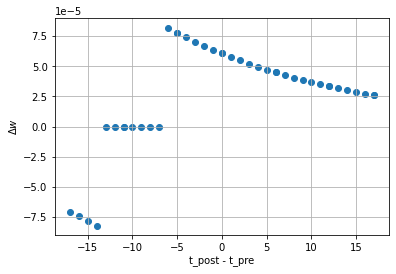

In [12]:
sim_time = 1000.  # [ms]
pre_spike_time = 20. #100. #sim_time / 2  # [ms]

dt_vec = []
dw_vec = []
for post_spike_time in np.linspace(1 + .05 * 2 * pre_spike_time, .95 * 2 * pre_spike_time - 1, 41): #111
    dt, dw = run_stdp_network(pre_spike_time, post_spike_time,
                      neuron_model_name,
                      synapse_model_name,
                      resolution=1., # [ms]
                      delay=10., # [ms]
                      sim_time=sim_time)
    dt_vec.append(dt)
    dw_vec.append(dw)

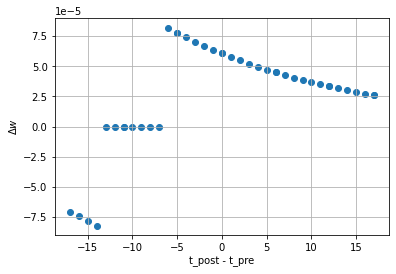

In [13]:


fig, ax = plt.subplots()
ax.scatter(dt_vec, dw_vec)
ax.set_xlabel(r"t_post - t_pre")
ax.set_ylabel(r"$\Delta w$")

for _ax in [ax]:
    _ax.grid(which="major", axis="both")
    _ax.grid(which="minor", axis="x", linestyle=":", alpha=.4)
    #_ax.minorticks_on()
    #_ax.set_xlim(0., sim_time)


Further directions
----------

* Other window shapes

References
----------

[1] Morrison A., Diesmann M., and Gerstner W. (2008) Phenomenological models of synaptic plasticity based on spike timing, Biol. Cybern. 98, 459–478
2

[2] Front. Comput. Neurosci., 23 November 2010 | https://doi.org/10.3389/fncom.2010.00141 Enabling functional neural circuit simulations with distributed computing of neuromodulated plasticity, Wiebke Potjans, Abigail Morrison and Markus Diesmann
3

[3] Rubin, Lee and Sompolinsky. Equilibrium Properties of Temporally Asymmetric Hebbian Plasticity. Physical Review Letters, 8 Jan 2001, Vol 86, No 2
4(1,2,3)

[4] Pfister JP, Gerstner W (2006). Triplets of spikes in a model of spike timing-dependent plasticity. The Journal of Neuroscience 26(38):9673-9682. DOI: https://doi.org/10.1523/JNEUROSCI.1425-06.2006

Acknowledgements
----------------

The authors thank Younes Bouhadjar for his suggestions on use-cases and valuable feedback.

This software was developed in part or in whole in the Human Brain Project, funded from the European Union’s Horizon 2020 Framework Programme for Research and Innovation under Specific Grant Agreements No. 720270 and No. 785907 (Human Brain Project SGA1 and SGA2).

License
-------

This notebook (and associated files) is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 2 of the License, or (at your option) any later version.

This notebook (and associated files) is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.